<strong>Library and modules

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import time
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from torch.autograd import grad
import torch.nn as nn 

<strong>Training and Test datasets, Definition of constants

In [2]:
#load train and test dataset

#list of timesteps t to train PINN model
#x_train = torch.tensor([np.linspace(0, 6, 100)], dtype = torch.float32).reshape(-1,1)
x_train = torch.load('%s/data/x_train.pt'%os.getcwd())
x_train.requires_grad = True

#test datasets to test PINN model
x_test = torch.load('%s/data/x_test.pt'%os.getcwd())
x_test.requires_grad = True
y_test_R15 = torch.load('%s/data/y_test_R=1.5.pt'%os.getcwd())
y_test_R40 = torch.load('%s/data/y_test_R=4.pt'%os.getcwd())
y_test_R60 = torch.load('%s/data/y_test_R=6.pt'%os.getcwd())

<strong>Definition of constants

In [3]:
#assign given constants from the problem
L = 1.2 #Henries
C = 0.3 #Farads
V0 = 12 #Volts

<strong>Defining NN model (y(t))

In [6]:
def train_nn(x_train, lr = 0.001, num_epoch = 10000, resistance = 1.5, act_fun = torch.nn.LogSigmoid(), plot_add = False, threshold = 0.01):
    # Define an empty list to store loss history
    train_loss_history = []
    loss_1_history = []
    loss_2_history = []
    loss_3_history = []
    test_loss_history = []
    n = len(x_train)
    # Time 
    t_start = time.time()
    date = time.strftime('%Y%m%d %H:%M:%S')

    h=20
    #============================================#
    nn = torch.nn.Sequential(
        torch.nn.Linear(1,h),
        act_fun,
        torch.nn.Linear(h,h),
        act_fun,
        torch.nn.Linear(h,1)
    )
    #============================================#
    # Optimizer: use Adam
    optimizer = torch.optim.Adam(nn.parameters(), lr = lr)
    
    # Loss function: use the MEAN SQUARED ERROR (MSE) as loss
    loss_function = torch.nn.MSELoss()
    #initial loss weight
    w1 = 1
    w2 = 1
    w3 = 1
    loss_ratio = [1,1,1]
    for epoch in range(num_epoch):
        y_pred_train = nn(x_train)
        #========<< INDUCTIVE BIAS WITHIN LOSS FUNCTION >>========
        # 1. Calculation of 1st/2nd order derivatives
        dy_dt = grad(outputs = y_pred_train,
                     inputs = x_train,
                     grad_outputs = torch.ones_like(y_pred_train),
                     create_graph =  True)[0]
        
        dy_dt2 =grad(outputs = dy_dt,
                     inputs = x_train,
                     grad_outputs = torch.ones_like(dy_dt),
                     create_graph =  True)[0]
        
        # 2. 2nd order ODE and Initial conditions
        ode = torch.tensor(np.zeros(len(x_train)), dtype = torch.float32)  # 2nd order ODE
        IC1 = torch.tensor([0.])   # Initial condition 1
        IC2 = torch.tensor([V0/L]) # Initial condition 2
        R = torch.tensor([resistance])
        ode_result = dy_dt2 + (R/L) * dy_dt + (1/(L*C)) * y_pred_train
        
        y_t0 = torch.tensor([y_pred_train[0]]) # y(t) at t = 0
        dy_dt_t0 = torch.tensor([dy_dt[0]]) # dydt at t = 0 
    
        loss_1 = loss_function(ode, ode_result)
        loss_2 = loss_function(IC1, y_pred_train[0])
        loss_3 = loss_function(IC2, dy_dt[0])
        train_loss = w1*loss_1 + w2*loss_2 + w3*loss_3
        if train_loss < threshold: 
            break
        #w1 = train_loss.detach().item()*loss_ratio[0]/(sum(loss_ratio)*loss_1.detach().item())
        #w2 = train_loss.detach().item()*loss_ratio[1]/(sum(loss_ratio)*loss_2.detach().item())
        #w3 = train_loss.detach().item()*loss_ratio[2]/(sum(loss_ratio)*loss_3.detach().item())
    
        loss_1_history.append(loss_1.detach().item())
        loss_2_history.append((loss_1 + loss_2).detach().item())
        loss_3_history.append((loss_1 + loss_2 + loss_3).detach().item())
        train_loss_history.append(train_loss.detach().item())
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    t_end = time.time()
    
    t = t_end - t_start

    #Plot test data
    plt.figure(figsize = (5,4), dpi = 120)
    #plt.text(0.1, 3.8, 'number of train data point: %s' %n, size=7, color='red')
    plt.text(0.1, -1.3, 'act_function: %s' %str(act_fun), size=7, color='blue')
    plt.plot(x_test.detach().numpy(), nn(x_test).detach().numpy(), label = 'NN for R = %s'%resistance, ls = '--', color = [1, 0, 0])
    plt.plot(x_test.detach().numpy(), y_test_R15.detach().numpy(), label = 'R = 1.5', alpha = 0.5)
    #plt.plot(x_test.detach().numpy(), y_test_R40.detach().numpy(), label = 'R = 4', alpha = 0.5)
    #plt.plot(x_test.detach().numpy(), y_test_R60.detach().numpy(), label = 'R = 6', alpha = 0.5)
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Current')
    plt.axhline(y = 0, color = [0.5, 0.5, 0.5])
    plt.xlim(0, 6)
    plt.ylim(-1.5, 4)
    plt.suptitle('Actual vs. Prediction', weight = 'bold', fontsize = 13, y = 0.93)
    plt.title('%s, lr = %s, num_epoch = %s'%(date, lr, epoch), fontsize  = 8, loc = 'right')
    plt.grid(alpha = 0.2)
    plt.tight_layout()
    plt.show()

    plt.plot(train_loss_history, label = 'Loss')
    plt.title('%s, lr = %s, num_epoch = %s'%(date, lr, epoch), fontsize  = 8, loc = 'right')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

    #Plot scatter
    if resistance == 1.5:
        y_test = y_test_R15.detach().numpy()
    if resistance == 4:
        y_test = y_test_R40.detach().numpy()
    if resistance == 6:
        y_test = y_test_R60.detach().numpy()
    ymin = min(nn(x_test).detach().numpy()) - 0.1
    ymax = max(nn(x_test).detach().numpy()) + 0.1
    
    plt.figure(figsize = (5,5), dpi = 150)
    plt.title('%s, lr = %s, num_epoch = %s, R2 = %s'%(date, lr, epoch, r2_score(nn(x_test).detach().numpy(),y_test)), fontsize  = 8, loc = 'right')
    plt.plot(np.linspace(ymin, ymax, 50), np.linspace(ymin, ymax, 50), color = 'red')
    plt.ylim(ymin, ymax)
    plt.xlim(ymin, ymax)
    plt.scatter(y_test, nn(x_test).detach().numpy(), color = 'blue', alpha = 0.2,)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(alpha = 0.2)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    if plot_add:
    #Plot train loss(composition)
        plt.figure(figsize = (5,4), dpi = 150)
        plt.suptitle('Train Loss', weight = 'bold', fontsize = 13, y = 0.93)
        plt.title('%s, lr = %s, num_epoch = %s'%(date, lr, epoch), fontsize  = 8, loc = 'right')
        plt.bar(list(range(num_epoch)),loss_3_history, label = 'ODE Loss', width = 1, color = [56/255,97/255,140/255])
        plt.bar(list(range(num_epoch)),loss_2_history, label = 'IC1 Loss', width = 1, color = [255/255,231/255,76/255])
        plt.bar(list(range(num_epoch)),loss_1_history, label = 'IC2 Loss', width = 1, color = [255/255,89/255,100/255])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.tight_layout()
        plt.xscale('log')
        plt.legend()
        plt.show()
        plt.close()

    #Plot scatter
        if resistance == 1.5:
            y_test = y_test_R15.detach().numpy()
        if resistance == 4:
            y_test = y_test_R40.detach().numpy()
        if resistance == 6:
            y_test = y_test_R60.detach().numpy()
        ymin = min(nn(x_test).detach().numpy()) - 0.1
        ymax = max(nn(x_test).detach().numpy()) + 0.1
        plt.figure(figsize = (5,5), dpi = 150)
        plt.title('%s, lr = %s, num_epoch = %s, R2 = %s'%(date, lr, num_epoch, r2_score(nn(x_test).detach().numpy(),y_test)), fontsize  = 8, loc = 'right')
        plt.plot(np.linspace(ymin, ymax, 50), np.linspace(ymin, ymax, 50), color = 'red')
        plt.ylim(ymin, ymax)
        plt.xlim(ymin, ymax)
        plt.scatter(y_test, nn(x_test).detach().numpy(), color = 'blue', alpha = 0.2,)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(alpha = 0.2)
        plt.tight_layout()
        plt.show()
        plt.close()
    return nn, train_loss_history, t
    
    

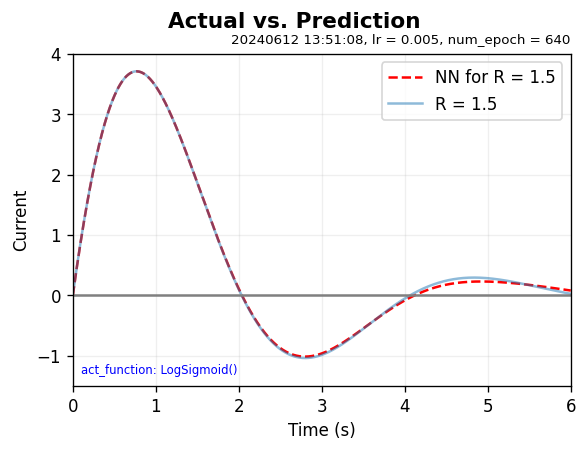

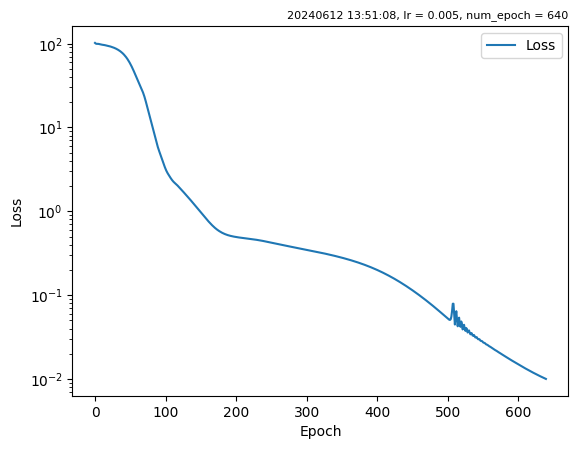

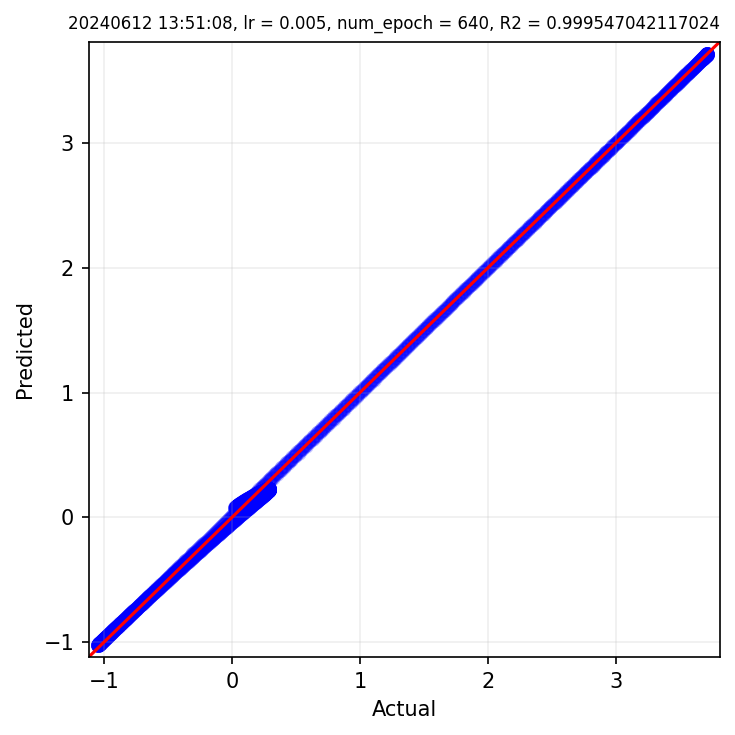

In [7]:
model_15 = train_nn(x_train, lr = 0.005, num_epoch = 50000, resistance = 1.5)
#model_40 = train_nn(x_train, lr = 0.005, num_epoch = 50000, resistance = 4)
#model_60 = train_nn(x_train, lr = 0.005, num_epoch = 50000, resistance = 6)